In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
covid_cases_file = './data/New_cases_nh.xlsx'
sirs_data_file = './data/Dartmouth Data Set- SIRS .xlsx'

covid_cases_df = pd.read_excel(covid_cases_file)
sirs_data_df = pd.read_excel(sirs_data_file)

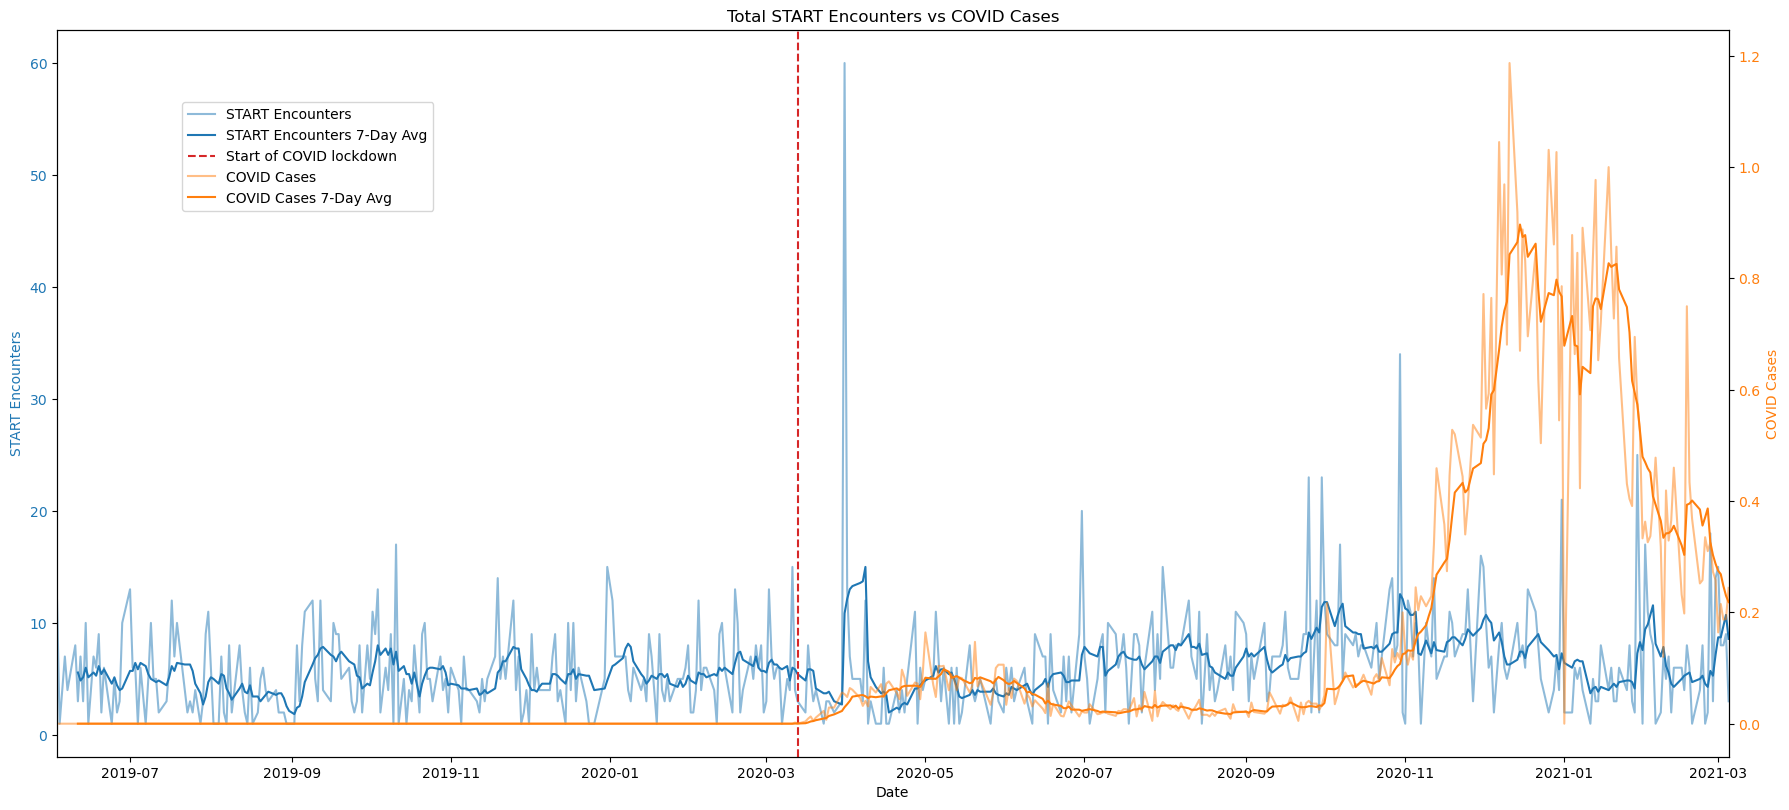

In [19]:
# Step 1: Extract and aggregate START encounters by date
sirs_data_df['Status Date'] = pd.to_datetime(sirs_data_df['Status Date'])
start_encounters = sirs_data_df.groupby(sirs_data_df['Status Date'].dt.date).size().reset_index(name='START Encounters')

# Step 2: Aggregate daily COVID cases
covid_cases_df['Date'] = pd.to_datetime(covid_cases_df['Date'])
covid_cases_aggregated = covid_cases_df.groupby(covid_cases_df['Date'].dt.date)['New cases'].sum().reset_index()

# Step 3: Extend COVID data into past (COVID cases are roughly 0 before March 2020) so we can look at pre-COVID vs post-COVID encounters
start_date = datetime.date(2019, 6, 1)
end_date = covid_cases_aggregated['Date'].max()

# Create a date range
date_range = pd.date_range(start_date, end_date).date

# Initialize empty df with the date range
extended_data = pd.DataFrame(date_range, columns=['Date'])

# Merge with the existing data to fill in the data points
extended_data = pd.merge(extended_data, covid_cases_aggregated, on='Date', how='left')

# Fill missing values for COVID cases with 0
extended_data['New cases'] = extended_data['New cases'].fillna(0)

# Merge data based on dates
merged_data = pd.merge(start_encounters, extended_data, left_on='Status Date', right_on='Date', how='inner')
merged_data = merged_data[['Date', 'START Encounters', 'New cases']]

# Calculate rolling averages
merged_data['START Encounters Rolling Avg'] = merged_data['START Encounters'].rolling(window=7).mean()
merged_data['New cases Rolling Avg'] = merged_data['New cases'].rolling(window=7).mean()

# Plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.set_xlabel('Date')
ax1.set_ylabel('START Encounters', color='tab:blue')
ax1.plot(merged_data['Date'], merged_data['START Encounters'], label='START Encounters', color='tab:blue', alpha=0.5)
ax1.plot(merged_data['Date'], merged_data['START Encounters Rolling Avg'], label='START Encounters 7-Day Avg', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('COVID Cases', color='tab:orange')  #  already handled the x-label with ax1
ax2.plot(merged_data['Date'], merged_data['New cases'], label='COVID Cases', color='tab:orange', alpha=0.5)
ax2.plot(merged_data['Date'], merged_data['New cases Rolling Avg'], label='COVID Cases 7-Day Avg', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add vertical line on March 13
march_13 = datetime.date(2020, 3, 13)
ax1.axvline(march_13, color='tab:red', linestyle='--', label='Start of COVID lockdown')

# Set x-axis limits to the range of  data
ax1.set_xlim([merged_data['Date'].min(), merged_data['Date'].max()])

fig.tight_layout()  # otherwise the line labels are slightly clipped
plt.title('Total START Encounters vs COVID Cases')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()